In [ ]:
!pip install grad-cam
!pip install timm

import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
from torchvision import models

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import timm


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
file_name_25_img = 'imagenet_val_25.npz'
if not os.path.exists(file_name_25_img):
    !wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-b/imagenet_val_25.npz

f = np.load("imagenet_val_25.npz", allow_pickle=True)
X, y, class_names = f["X"], f["y"], f["label_map"].item()
class_names_to_id = {name: id for id, name in class_names.items()}

y_long = torch.tensor(y, dtype=torch.long)
one_hot_y = F.one_hot(y_long, num_classes = 1000)
one_hot_y = one_hot_y.float()

plt.figure(figsize=(15, 7))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()


In [ ]:
def rescale(x):
    low, high = 0, 255
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

X_scaled = rescale(X)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class Preprocessing_Transform:
    def __init__(self, mean, std, model_name):
        self.mean = mean
        self.std = std
        self.model_name = model_name

    def __call__(self, img):
        if self.model_name == "inceptionv4":
            img_resized = np.zeros((len(img), 299, 299, 3), dtype=np.float32)  # Initialize resized array
            for i in range(len(img)):
                img_pil = Image.fromarray(np.uint8(img[i] * 255))  # Convert to PIL image
                img_pil = img_pil.resize((299, 299))  # Resize image
                img_resized[i] = np.array(img_pil) / 255.0  # Convert back to numpy array and normalize
        elif self.model_name == "squeezenet":
            img_resized = img  # No resize
        img_normalized = (img_resized - np.array(self.mean)[None, None, None, :]) / np.array(self.std)[None, None, None, :] # Normalize
        return torch.tensor(img_normalized, dtype=torch.float32).permute(0, 3, 1, 2)

class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

preprocess_squeezenet = transforms.Compose([
    Preprocessing_Transform(mean, std, "squeezenet")
])

preprocess_inceptionv4 = transforms.Compose([
    Preprocessing_Transform(mean, std, "inceptionv4")
])

unpreprocessed_dataset = NumpyDataset(X_scaled)
dataset_squeezenet = preprocess_squeezenet(unpreprocessed_dataset)
dataset_inceptionv4 = preprocess_inceptionv4(unpreprocessed_dataset)


print(dataset_squeezenet.shape, dataset_inceptionv4.shape)

torch.Size([25, 3, 224, 224]) torch.Size([25, 3, 299, 299])


In [ ]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # activate gradients on X
    model.eval()
    X.requires_grad = True
    N, _, H, W = X.shape
    yhat = model(X)

    if X.grad is not None:  # Is it necessary ?
        X.grad.zero_()

    # Select yhat_i for each row
    yhat_i = yhat[np.arange(N), y]

    # Backward
    yhat_i.backward(torch.ones_like(yhat_i))
    saliency, _ = torch.max(X.grad.data.abs(), dim=1)

    return saliency

In [ ]:
# Load the model
resnet50_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
resnet50_model.to(device)

# Freeze the weights
for param in resnet50_model.parameters():
    param.requires_grad = False

# Model in test mode
resnet50_model.eval()

target_layer_resnet50 = resnet50_model.layer4[-1]

# Load the model
squeezenet_model = torchvision.models.squeezenet1_1(weights=torchvision.models.SqueezeNet1_1_Weights.DEFAULT)
squeezenet_model.to(device)

# Freeze the weights
for param in squeezenet_model.parameters():
    param.requires_grad = False

# Model in test mode
squeezenet_model.eval()

target_layer_squeezenet = squeezenet_model.features[-1]

inceptionv4_model = timm.create_model('inception_v4', pretrained=True)
inceptionv4_model.to(device)

# Freeze the weights
for param in inceptionv4_model.parameters():
    param.requires_grad = False

# Model in test mode
inceptionv4_model.eval()

target_layer_inceptionv4 = inceptionv4_model.features[-1]

In [ ]:
input_tensor = torch.clone(dataset_squeezenet).detach().requires_grad_(True)

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=squeezenet_model, target_layers=[target_layer_squeezenet])

targets = [ClassifierOutputTarget(class_id) for class_id in y]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

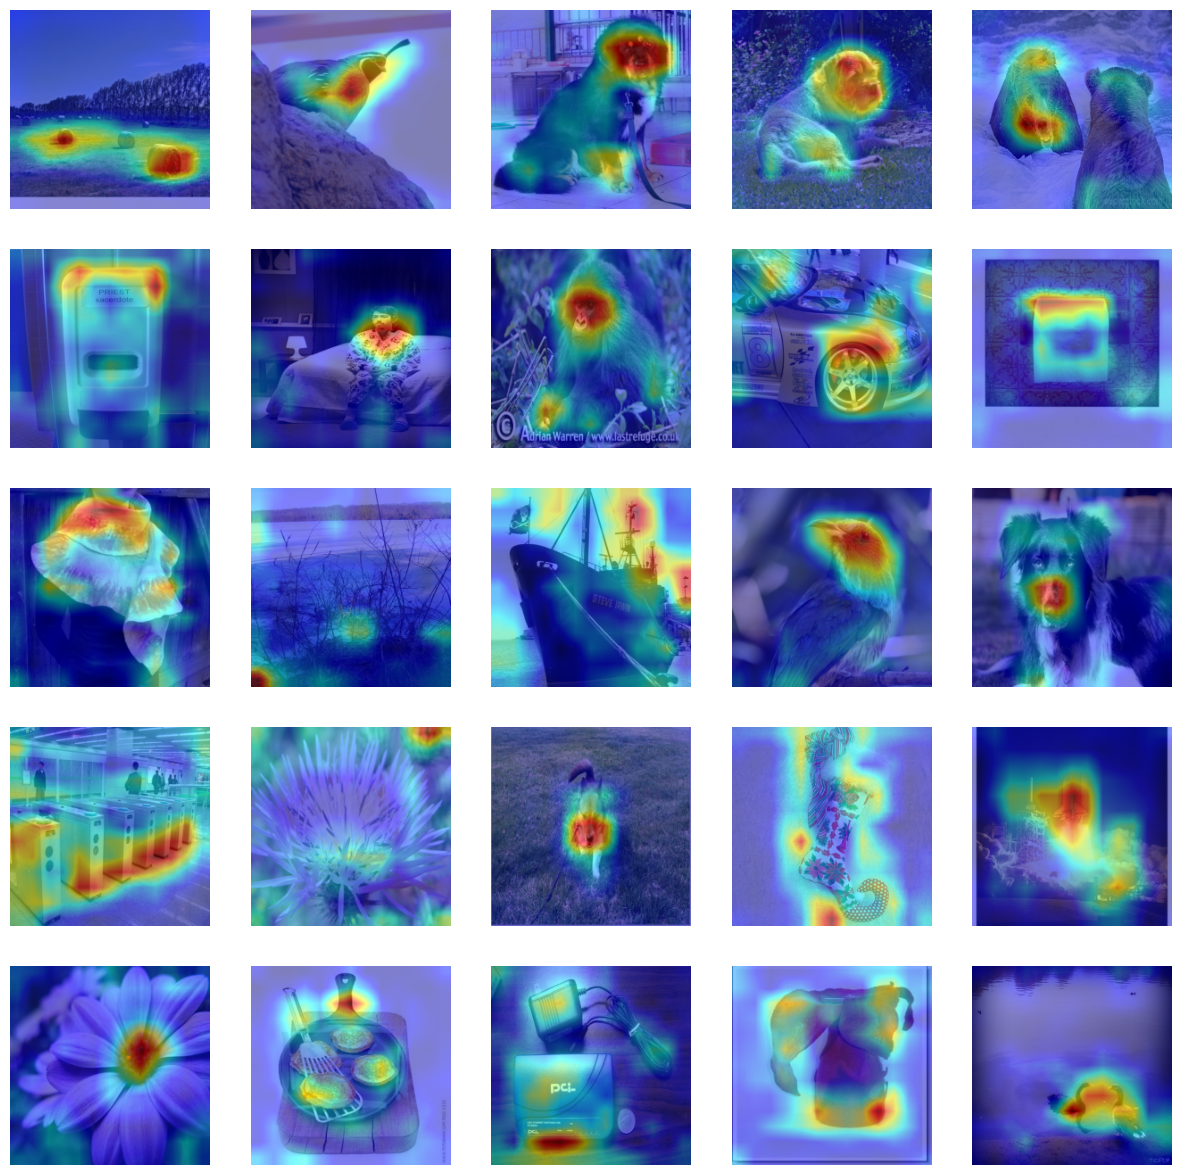

In [ ]:
grayscale_cams = [cam.squeeze() for cam in grayscale_cam]  # Removing any extra dimensions

num_images_to_display = 25

columns = 5  # Number of columns in the grid
rows = math.ceil(num_images_to_display / columns)  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 3))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i in range(num_images_to_display):
    if i < len(X):
        # Normalize image
        img = X[i] / 255.0
        img = np.float32(img)  # Ensure it's float32

        # Get the corresponding CAM
        cam_image = grayscale_cams[i]

        # Overlay CAM on the image
        visualization = show_cam_on_image(img, cam_image, use_rgb=True)

        ax = axes[i]
        ax.imshow(visualization)
        ax.axis('off')
    else:
        break  # Break if there are no more images

# Hide any unused axes if there are fewer images than subplots
for ax in axes[num_images_to_display:]:
    ax.axis('off')

plt.show()

**Implementation avec inception_v4**

In [ ]:
def preprocess_inception_v4(img, size=299):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
        transforms.Lambda(lambda x: x[None]),  # add one dimension
    ])
    return transform(img)

In [ ]:
with torch.no_grad():
    out = model(torch.Tensor(X[0]).permute(2,0,1).unsqueeze(0))
probabilities = torch.nn.functional.softmax(out[0], dim=0)
print(probabilities.shape)

torch.Size([1000])


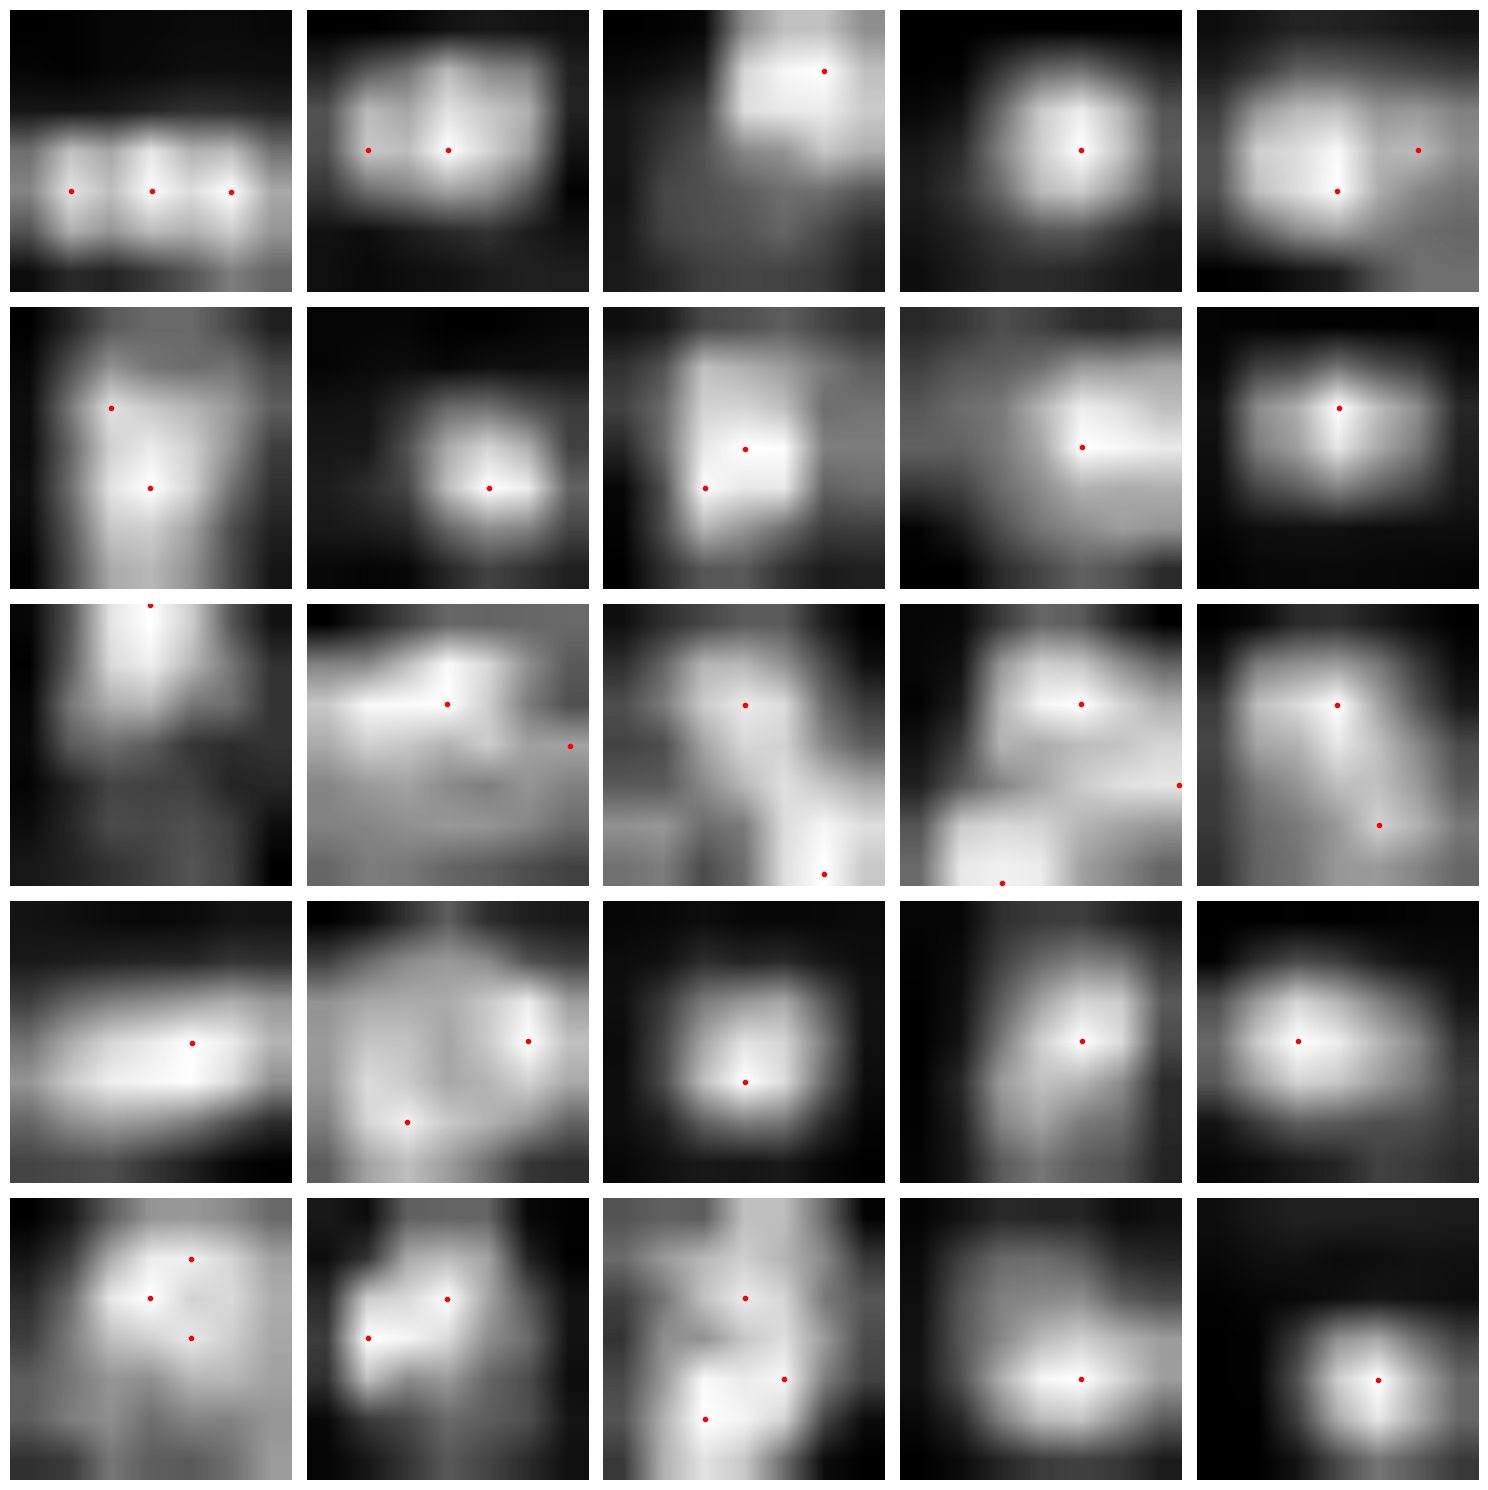

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

# Assuming grayscale_cams is defined
# Example adjustment: Let's create a dummy list of 25 random images for demonstration
# grayscale_cams = [np.random.rand(100, 100) for _ in range(25)]

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    M = grayscale_cams[i]
    ax.imshow(M, cmap='gray')

    # Find coordinates of local maxima
    coordinates = peak_local_max(M, num_peaks=3, exclude_border=False, min_distance=20)

    # Extract the values at these coordinates
    maxima_values = M[coordinates[:, 0], coordinates[:, 1]]

    # Determine the highest value among the maxima
    highest_maxima_value = max(maxima_values)

    # Filter coordinates based on the threshold
    filtered_coordinates = coordinates[maxima_values >= 0.6 * highest_maxima_value]

    # Plot the filtered coordinates on the images
    ax.plot(filtered_coordinates[:, 1], filtered_coordinates[:, 0], 'r.')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
def get_centers(M, ratio_threshold = 0.6, min_distance = 20):
    # Find coordinates of local maxima
    coordinates = peak_local_max(M, num_peaks=3, exclude_border=False, min_distance=min_distance)

    if len(coordinates)==0:
      global_max_index = np.unravel_index(np.argmax(M), M.shape)
      return np.array([global_max_index]), True

    # Extract the values at these coordinates
    maxima_values = M[coordinates[:, 0], coordinates[:, 1]]

    # Determine the highest value among the maxima
    highest_maxima_value = max(maxima_values)

    # Filter coordinates based on the threshold
    filtered_coordinates = coordinates[maxima_values >= ratio_threshold * highest_maxima_value]
    return filtered_coordinates, False

In [ ]:
def ADP(x_clean, y_true, model, ratio_threshold, min_distance, eps, T, alpha, beta, m):
  #y_true = np.argmax(torch.nn.functional.softmax(model(x_clean)[0], dim=0))

  target_layers = [model.layer4[-1]]
  cam = GradCAM(model=model, target_layers=target_layers)

  targets = [ClassifierOutputTarget(np.argmax(y_true))]

  x_adv = torch.clone(x_clean).detach()

  W, H = x_clean.shape[1], x_clean.shape[2]

  criterion = torch.nn.CrossEntropyLoss()

  for t in range(0, T):
    g=0
    M = cam(input_tensor=x_adv, targets=targets)

    centers, use_global = get_centers(M[0], ratio_threshold, min_distance)

    if use_global:
      plt.imshow(M[0])

    for center in centers:

      for k in range(1, m+1):
        x1 = int(max(center[0]-beta*k, 0))
        x2 = int(min(center[0]+beta*k, W))
        y1 = int(max(center[1]-beta*k, 0))
        y2 = int(min(center[1]+beta*k, H))

        x_drop = torch.clone(x_adv).detach()
        x_drop[:, x1:x2, y1:y2] = x_clean[:, x1:x2, y1:y2]
        x_drop = x_drop.detach()
        x_drop.requires_grad_(True)

        loss = criterion(model(x_drop)[0], y_true)
        loss.backward()

        grad = x_drop.grad.data
        g += grad

    g *= 1/(len(centers)*m)


    x_adv_max = x_adv + eps
    x_adv_min = x_adv - eps
    x_adv_max.clamp_(0,1)
    x_adv_min.clamp_(0,1)

    with torch.no_grad():
      g_sign = g.sign()
      perturbed_x_adv = x_adv + alpha * g_sign
      x_adv.data = torch.max(torch.min(perturbed_x_adv.data, x_adv_max), x_adv_min)

  return x_adv

In [ ]:
x_clean = torch.Tensor(X[0]).permute(2,0,1).unsqueeze(0)
y_true = one_hot_y[0]

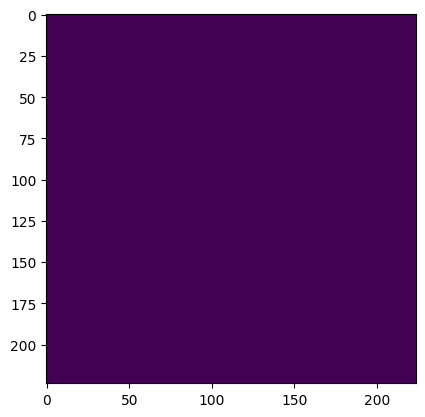

In [ ]:
x_adv = ADP(x_clean, y_true, model, ratio_threshold=0.6, min_distance=20, eps=16/255, T=10, alpha=1.6, beta=15, m=5)

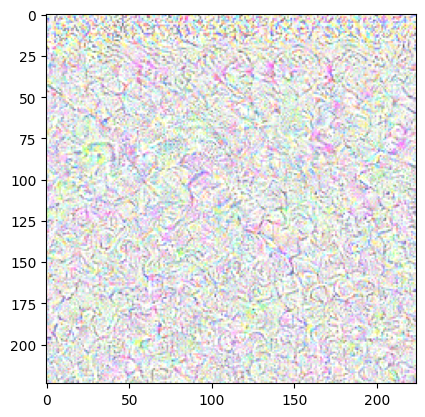

In [ ]:
plt.imshow(x_adv.squeeze().permute(1,2,0).detach().cpu().numpy())

In [ ]:
a = torch.Tensor([[1,2,3], [4,5,6], [7,8,9]])
b = torch.Tensor([[10,11,12], [13,14,15], [16,17,18]])

In [ ]:
a[:2, 1:2] = b[:2, 1:2]

In [ ]:
a

tensor([[ 1., 11.,  3.],
        [ 4., 14.,  6.],
        [ 7.,  8.,  9.]])